In this notebook we will experiment with the AL bias mitigation technique from Richards. 
We will do this on a synthetically biased sample (sample size=700) that we obtained from the CERN dataset, with the rf classifier trained on 10 percent of the data and using a=1/28 and k=0 for the bin distribution

In [ ]:
# Some notes:
# - If you use df.loc[i], you get the instance that had index i in the original dataframe.
# - If you use df.l=iloc[i], you get the ith instance n the current dataframe.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time

# Import data

In [2]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [3]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Prototypes/CERN_sampled_rf_0.1_dis_004_000.csv"

df= read_file(url)


In [4]:
# create sample and pool
sample_3000=df[df['in_biased_sample']==1]
pool_3000=df[df['in_biased_sample']==0]

In [1]:
#df = pd.read_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')
#df=pd.read_csv('CERN_testing_set_30_2000.csv')
#df=pd.read_csv('CERN_testing_set_5_100.csv')
df=pd.read_csv('CERN_testing_set_500_20000.csv')

NameError: name 'pd' is not defined

# Visualize data

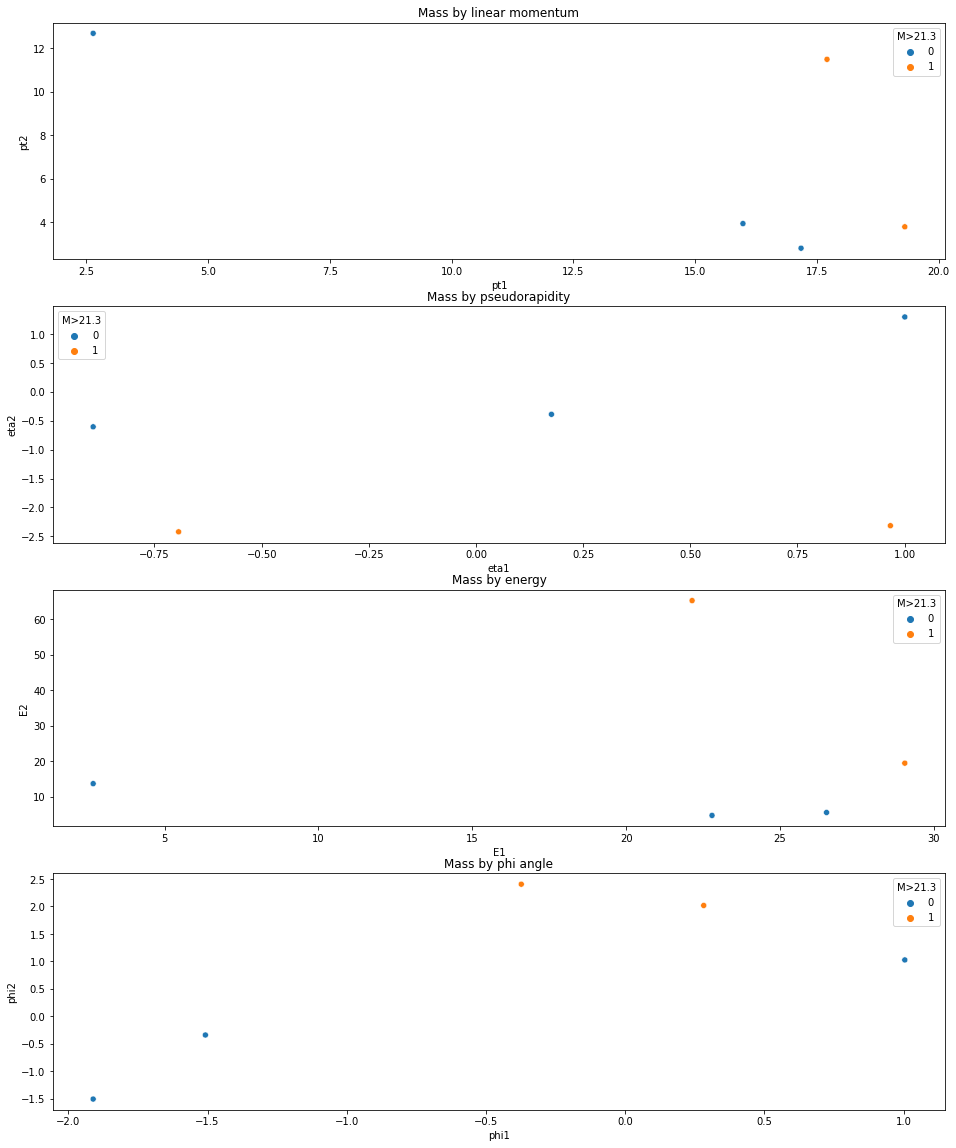

In [159]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

NameError: name 'sample_700' is not defined

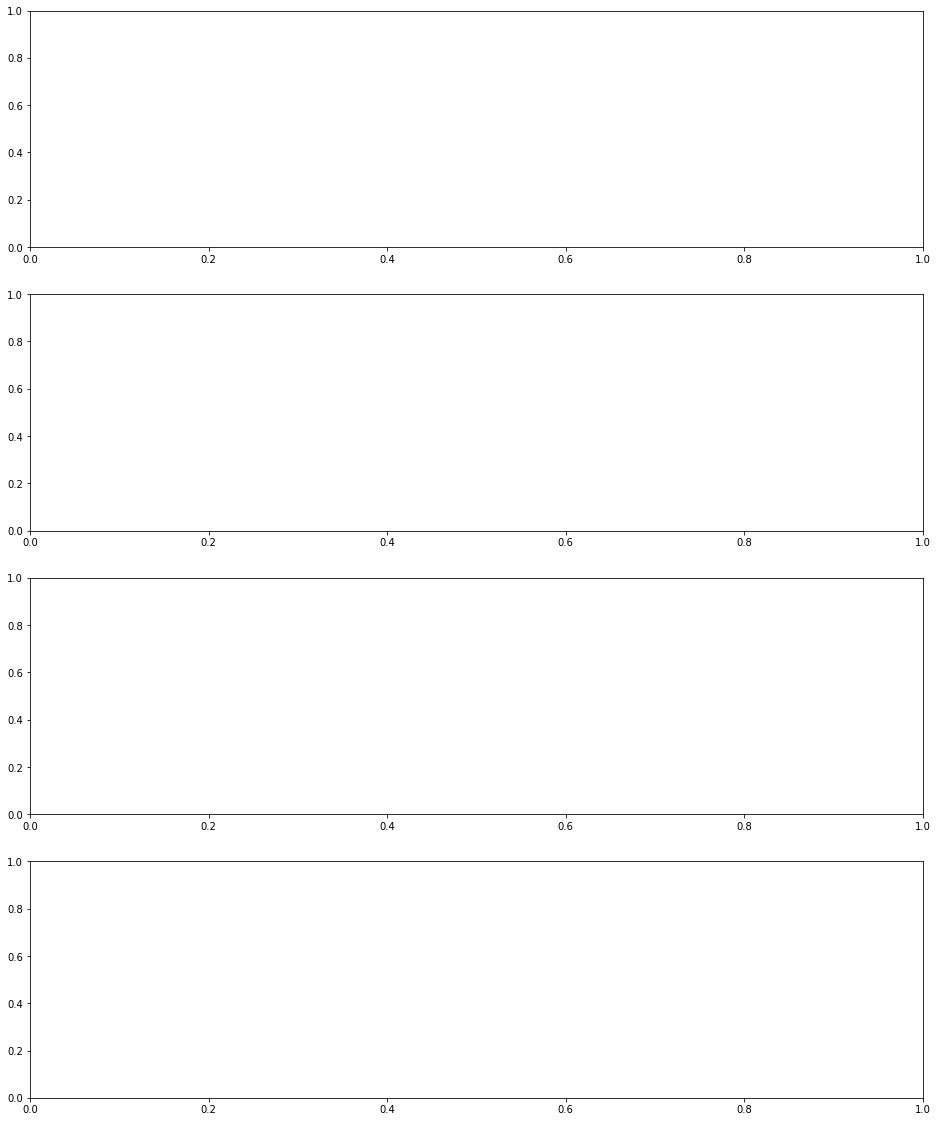

In [6]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_700, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_700, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_700, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_700, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Prep data

In [19]:
# create sample and pool, the sample has size 700
sample=df[df['in_biased_sample']==1]
pool=df[df['in_biased_sample']==0]

X=df.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
y=df.M>21.3
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
    


In [190]:
prep_data

<function __main__.prep_data()>

In [202]:
X_pool

,Unnamed: 0,Unnamed: 0.1,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
5,5,23605,95.79420,20.476400,8.278980,-93.21330,22.08670,-2.146810,0.384223,-1,52.91740,-6.851290,-7.75341,-51.896000,10.34680,-2.315510,-2.294500,1
6,6,68617,2.35481,0.807006,1.855970,1.20384,2.02383,0.564390,1.160640,-1,223.02400,31.868100,-11.50580,220.436000,33.88150,2.571740,-0.346482,-1
7,7,68686,22.86210,-4.708890,-21.516200,6.12843,22.02540,0.274773,-1.786250,1,3.14388,-1.349270,-2.83922,-0.047938,3.14351,-0.015249,-2.014430,-1
8,8,43328,6.09816,-1.819920,0.773974,-5.76857,1.97766,-1.791820,2.739490,-1,67.47230,24.595900,-3.38853,62.738100,24.82820,1.657170,-0.136906,1
9,9,77245,27.45950,-10.913800,15.530200,-19.84260,18.98150,-0.913090,2.183360,-1,13.31710,-3.458610,-3.37843,12.408400,4.83485,1.671630,-2.367920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,82739,93.11870,43.357800,-15.192300,80.99620,45.94240,1.332330,-0.337025,1,25.93160,-5.696650,3.44697,25.062200,6.65833,2.035840,2.597440,1
101,101,3204,128.46800,23.769600,-12.800500,-125.59900,26.99720,-2.241860,-0.493988,-1,50.92270,14.479000,-6.89063,-48.332200,16.03510,-1.822910,-0.444186,-1
102,102,87657,51.28580,-5.027560,-14.844000,48.83250,15.67230,1.854460,-1.897360,-1,20.07310,-0.365496,-4.39293,19.583100,4.40811,2.196800,-1.653810,1
103,103,95697,75.18420,10.957000,-10.414600,73.64880,15.11690,2.287010,-0.760026,1,11.00500,2.933170,0.99119,10.560500,3.09612,1.940950,0.325877,-1


In [9]:
#_sample.index
#index=pd.Index(X_sample[])
X_sample.index.get_loc(603)

0

In [10]:
int(X_sample.iloc[0].iloc[0])

603

# Train rf classifier

In [144]:
#train classifier on sample
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_sample, y_sample)
print ('training time: ', round(time()-t0, 3), 's')

training time:  0.099 s


In [145]:
#accuracy on X (whole set)
t1=time()
pred_rf = rf.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.024 s
Accuracy: 0.6916256157635468


In [146]:
#accuracy on sample
t1=time()
pred_rf_sample = rf.predict(X_sample)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_sample, pred_rf_sample))


predicting time:  0.012 s
Accuracy: 1.0


## Random Forest

In [6]:
##get proximity matrix
def get_proximity_matrix(X, rf):
    
    #find proportion of indices that match between i and j
    #compute the symmetric matrix
    
    n=X.shape[0]
    tree_idxs = rf.apply(X)
    proximity_matrix = np.empty(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            proximity_matrix[i,j] = np.sum(np.equal(tree_idxs[i,:], tree_idxs[j,:]))
    return proximity_matrix

In [7]:
##get maximum probabilities
def get_max_class_probabilities(X,rf):
    class_probabilities= rf.predict_proba(X)
    max_class_probabilities=[0]*(len(class_probabilities))
    for i in range (len(class_probabilities)):
        max_class_probabilities[i]=max(class_probabilities[i,0],class_probabilities[i,1])
    return max_class_probabilities

In [8]:
#X=training set, pool=pool of instances to pick from
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
#proximity_matrix=get_proximity_matrix(X+pool,rf)

RandomForestClassifier()

## AL query functions

In [ ]:
def rho(x1, x2):
    

In [9]:
def get_sum_of_proximities(i1, ys, proximity_matrix):
    proximities=[0]*len(ys)
    for i in range(len(ys)):
        proximities[i]=proximity_matrix[i,i1]
    sum_of_proximities=sum(proximities)
    return sum_of_proximities
        

In [10]:
#to do!!!!

#U=indices of training set
#L=indices of pool

def s_2(i, pool):
    S_2 = get_sum_of_proximities(i, X_sample.index, proximity_matrix)*(1-max_class_probabilities[i])/(get_sum_of_proximities(i,X_pool.index, proximity_matrix)+1)
    return S_2

def uncertainty(i):
    return (1- max_class_probabilities[i])
    
def query_instance (X_sample, X_pool, rf):
    proximity_matrix = get_proximity_matrix(X, rf)
    max_class_probabilities= get_max_class_probabilities(X, rf)
    #s_2_scores=[0]*X_pool.shape[0]
    uncertainty_scores=[0]*X_pool.shape[0]
    for i in range(X_pool.shape[0]):
        #s_2_scores[i]=s_2(int(X_pool.iloc[i].iloc[0]), X_pool)
        uncertainty_scores[i]= uncertainty(int(X_pool.iloc[i].iloc[0]))
    
    #queried_instance_index = int(X_pool.iloc[np.argmax(s_2_scores)].iloc[0])
    queried_instance_index = int(X_pool.iloc[np.argmax(uncertainty_scores)].iloc[0])
    return queried_instance_index
    #what I want to do:
    #get all values of s2 for the instances in the pool in a list
    #get the argmax, which gives the index i with the highest s2 score
    #get the instancce from the pool by using 
    #int(X_sample.iloc[0].iloc[0])

## AL algorithm

In [20]:
# initialization of AL algorithm:
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=1
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample, y_sample)
    print ('cp1: ', round(time()-t0, 3), 's')
    
    #store accuracy
    pred_rf = rf.predict(X)
    accuracy = metrics.accuracy_score(y, pred_rf)
    accuracies[i] = accuracy
    #print (accuracy)
    print ('cp2: ', round(time()-t0, 3), 's')
    
    #query instance and add to sample
    proximity_matrix = get_proximity_matrix(X, rf)
    print ('cp3: ', round(time()-t0, 3), 's')
    max_class_probabilities= get_max_class_probabilities(X, rf)
    print ('cp4: ', round(time()-t0, 3), 's')
    n = query_instance(X_sample, X_pool, rf)
    print ('cp5: ', round(time()-t0, 3), 's')
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)
    
#store accuracy
pred_rf = rf.predict(X)
accuracy = metrics.accuracy_score(y, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)
print ('duration of 1 iteration: ', round(time()-t0, 3), 's')

cp1:  0.161 s
cp2:  0.299 s
cp3:  2081.03 s
cp4:  2081.153 s
cp5:  4167.153 s
0.8059512195121952
duration of 1 iteration:  4167.304 s


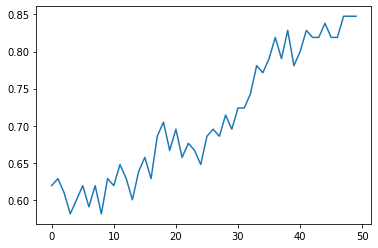

In [165]:
plt.plot(accuracies)

Text(0.5, 1.0, 'Accuracies /w uncertainty only')

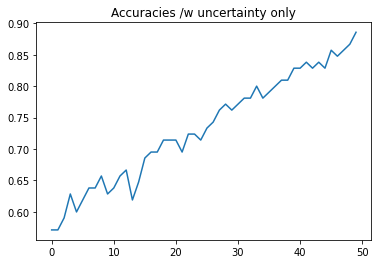

In [196]:
plt.plot(accuracies)
ax = plt.gca()
ax.set_title("Accuracies /w uncertainty only)

In [ ]:
accuracies_100_it_uncertainty=accuracies

Text(0.5, 1.0, 'Accuracies')

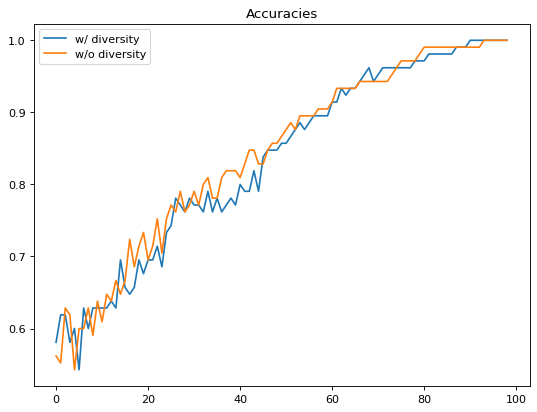

In [228]:
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_100_it, label="w/ bias criterion")
plt.plot(accuracies_100_it_uncertainty, label="w/o bias criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracies")

Text(0.5, 1.0, 'Accuracies, 100 iterations')

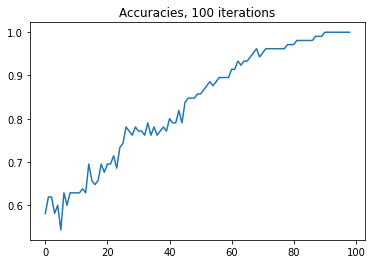

In [211]:
accuracies_100_it=accuracies
plt.plot(accuracies)
ax = plt.gca()
ax.set_title("Accuracies, 100 iterations")

Text(0.5, 1.0, 'Queried Instances')

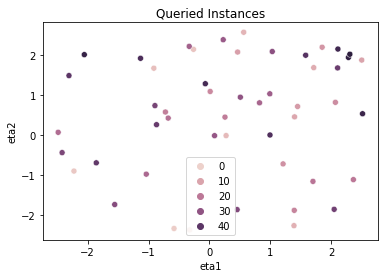

In [176]:
sns.scatterplot(data=X.loc[queried_instances], x='eta1', y='eta2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances")